In [11]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
# 导入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
# 真实数据和噪音数据
def get_inputs(real_size, noise_size):
    
    real_img = tf.placeholder(tf.float32, [None, real_size])
    noise_img = tf.placeholder(tf.float32, [None, noise_size])
    
    return real_img, noise_img

# 生成器
- noise_img:产生的噪音输入
- n_units:隐藏单元个数
- out_dim:输出的大小（28 28 1）

In [14]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

# 判别器
- img:输入
- n_units:隐层单元数量
- reuse:由于要使用两次

In [15]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

# 网络参数定义
- img_size: 输入大小
- noise_size: 噪音图像大小
- g_units: 生成器隐层参数
- d_units: 判别器隐层参数
- learning_rate: 学习率

In [16]:
img_size = mnist.train.images[0].shape[0]

noise_size = 100

g_units = 128

d_units = 128

learning_rate = 0.001

alpha = 0.01

img_size

784

# 构建网络

In [17]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

#discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

# 目标函数
- （1）对于生成网络要使得生成结果通过判别网络为真
- （2）对于判别网络要使输入为真实图像时判别为真 输入为生成图像时判别为假
    # 判别模型：log(D1(x))+log(1-D2(G(z)))
    # 生成模型：log(D2(G(z)))

In [18]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                     labels=tf.ones_like(d_logits_real)))
# 识别生成图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real,d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                labels = tf.ones_like(d_logits_fake)))


# 优化器

In [19]:
train_vars = tf.trainable_variables()

# generator
g_vars = [var for var in train_vars if var.name.startswith('generator')]
# discriminator
d_vars = [var for var in train_vars if var.name.startswith('discriminator')]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 训练

In [21]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list=g_vars)
#开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            #对图像像素进行scale, 这是因为tanh的输出结果结余（-1,1），real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            sess.run(d_train_opt, feed_dict={real_img:batch_images, noise_img:batch_noise})
            sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
         
        # if e % 10 == 0:
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, feed_dict={real_img: batch_images,
                                                   noise_img: batch_noise})
        
        #real img loss
        train_loss_d_real = sess.run(d_loss_real,
                                    feed_dict={real_img:batch_images,
                                              noise_img:batch_noise})
        
        #fake img loss
        train_loss_d_fake = sess.run(d_loss_fake,
                                    feed_dict={real_img:batch_images,
                                              noise_img:batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss,
                               feed_dict={noise_img:batch_noise})
        
        print('Epoch {}/{}...'.format(e+1,epochs),
             "判别器损失{:.4f}(判别真实的{:.4f}+ 判别生成的{:.4f})...".format(train_loss_d,train_loss_d_real,train_loss_d_fake),
              "生成器损失{:.4f}".format(train_loss_g)
             )
        
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 保存样本
        samples_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                              feed_dict={noise_img:samples_noise})
        samples.append(gen_samples)
        
        saver.save(sess, './checkpoints/generator.ckpt')

#保存本地
with open('train_samples.pkl','wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... 判别器损失0.0946(判别真实的0.0233+ 判别生成的0.0713)... 生成器损失3.1770
Epoch 2/300... 判别器损失0.4842(判别真实的0.3472+ 判别生成的0.1370)... 生成器损失4.0732
Epoch 3/300... 判别器损失0.0992(判别真实的0.0182+ 判别生成的0.0810)... 生成器损失4.8712
Epoch 4/300... 判别器损失1.5694(判别真实的0.8666+ 判别生成的0.7028)... 生成器损失2.8809
Epoch 5/300... 判别器损失2.4135(判别真实的1.4885+ 判别生成的0.9250)... 生成器损失0.8422
Epoch 6/300... 判别器损失1.9047(判别真实的0.7755+ 判别生成的1.1292)... 生成器损失0.4573
Epoch 7/300... 判别器损失1.3984(判别真实的1.0133+ 判别生成的0.3851)... 生成器损失1.3350
Epoch 8/300... 判别器损失1.6242(判别真实的1.0448+ 判别生成的0.5794)... 生成器损失1.1454
Epoch 9/300... 判别器损失1.6296(判别真实的0.7495+ 判别生成的0.8801)... 生成器损失2.0337
Epoch 10/300... 判别器损失0.6904(判别真实的0.2980+ 判别生成的0.3924)... 生成器损失2.3706
Epoch 11/300... 判别器损失1.4220(判别真实的0.8892+ 判别生成的0.5328)... 生成器损失1.6716
Epoch 12/300... 判别器损失1.5943(判别真实的0.7872+ 判别生成的0.8072)... 生成器损失1.6028
Epoch 13/300... 判别器损失1.0731(判别真实的0.7520+ 判别生成的0.3211)... 生成器损失1.6848
Epoch 14/300... 判别器损失1.5890(判别真实的0.8204+ 判别生成的0.7686)... 生成器损失1.2908
Epoch 15/300... 判别器损失2.2782(判别真实的1.5010+ 判别

Epoch 120/300... 判别器损失1.0270(判别真实的0.3359+ 判别生成的0.6911)... 生成器损失1.2003
Epoch 121/300... 判别器损失1.0336(判别真实的0.3743+ 判别生成的0.6593)... 生成器损失1.2603
Epoch 122/300... 判别器损失0.9855(判别真实的0.3493+ 判别生成的0.6362)... 生成器损失1.2731
Epoch 123/300... 判别器损失0.9598(判别真实的0.6033+ 判别生成的0.3565)... 生成器损失1.9690
Epoch 124/300... 判别器损失0.8759(判别真实的0.3743+ 判别生成的0.5017)... 生成器损失1.5035
Epoch 125/300... 判别器损失1.0145(判别真实的0.4404+ 判别生成的0.5741)... 生成器损失1.3009
Epoch 126/300... 判别器损失0.9316(判别真实的0.4787+ 判别生成的0.4529)... 生成器损失1.6667
Epoch 127/300... 判别器损失0.9838(判别真实的0.5752+ 判别生成的0.4086)... 生成器损失1.6625
Epoch 128/300... 判别器损失0.9811(判别真实的0.4340+ 判别生成的0.5471)... 生成器损失1.4491
Epoch 129/300... 判别器损失0.9078(判别真实的0.5068+ 判别生成的0.4010)... 生成器损失1.7505
Epoch 130/300... 判别器损失1.0508(判别真实的0.4185+ 判别生成的0.6323)... 生成器损失1.2553
Epoch 131/300... 判别器损失1.1642(判别真实的0.3879+ 判别生成的0.7762)... 生成器损失1.1788
Epoch 132/300... 判别器损失0.9096(判别真实的0.4634+ 判别生成的0.4462)... 生成器损失1.5467
Epoch 133/300... 判别器损失0.8938(判别真实的0.4283+ 判别生成的0.4655)... 生成器损失1.4062
Epoch 134/300... 判别器

Epoch 238/300... 判别器损失0.9254(判别真实的0.4371+ 判别生成的0.4882)... 生成器损失1.6046
Epoch 239/300... 判别器损失0.7929(判别真实的0.5264+ 判别生成的0.2664)... 生成器损失2.2295
Epoch 240/300... 判别器损失0.8980(判别真实的0.4351+ 判别生成的0.4630)... 生成器损失1.6793
Epoch 241/300... 判别器损失0.7793(判别真实的0.2894+ 判别生成的0.4899)... 生成器损失1.6634
Epoch 242/300... 判别器损失1.0565(判别真实的0.4254+ 判别生成的0.6311)... 生成器损失1.5022
Epoch 243/300... 判别器损失0.9143(判别真实的0.4777+ 判别生成的0.4366)... 生成器损失1.6534
Epoch 244/300... 判别器损失0.9004(判别真实的0.4622+ 判别生成的0.4382)... 生成器损失1.8595
Epoch 245/300... 判别器损失0.8076(判别真实的0.4335+ 判别生成的0.3741)... 生成器损失1.8420
Epoch 246/300... 判别器损失0.7159(判别真实的0.4025+ 判别生成的0.3134)... 生成器损失2.1057
Epoch 247/300... 判别器损失0.9356(判别真实的0.5031+ 判别生成的0.4324)... 生成器损失1.7150
Epoch 248/300... 判别器损失0.9326(判别真实的0.5835+ 判别生成的0.3491)... 生成器损失1.9698
Epoch 249/300... 判别器损失0.8785(判别真实的0.4444+ 判别生成的0.4341)... 生成器损失1.8860
Epoch 250/300... 判别器损失0.9519(判别真实的0.4436+ 判别生成的0.5083)... 生成器损失1.5469
Epoch 251/300... 判别器损失0.9021(判别真实的0.4981+ 判别生成的0.4040)... 生成器损失1.7967
Epoch 252/300... 判别器

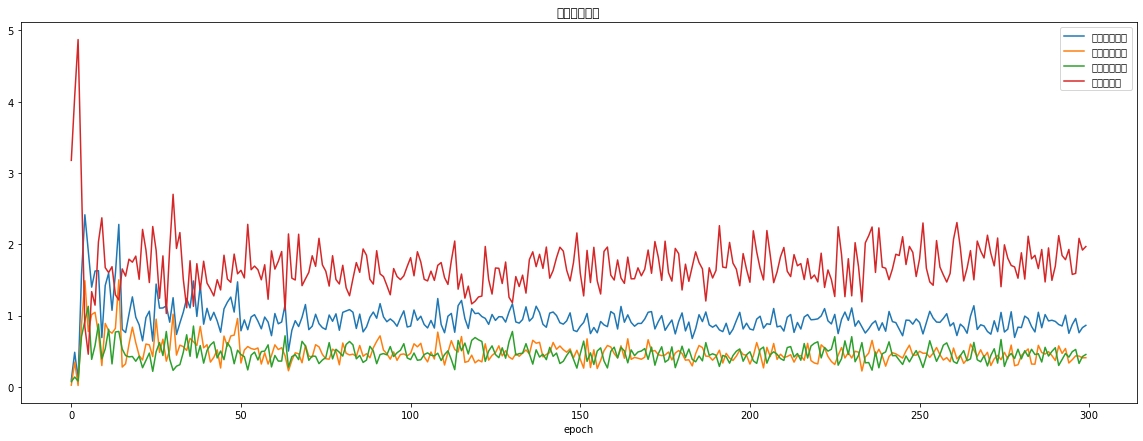

In [26]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label=u'判别器总损失')
plt.plot(losses.T[1], label=u'判别真实损失')
plt.plot(losses.T[2], label=u'判别生成损失')
plt.plot(losses.T[3], label=u'生成器损失')
plt.title('对抗生成网络')
ax.set_xlabel('epoch')
plt.legend()

In [27]:
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [30]:
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]):
        # samples[epoch][1]代表生成的图像结果
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)),cmap='Greys_r')
    return fig, axes

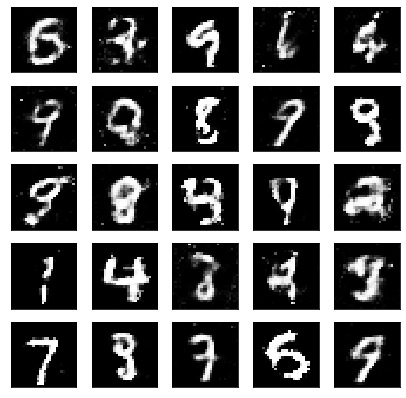

In [31]:
_ = view_samples(-1, samples)

In [32]:
epoch_idx = [10, 30, 60, 90, 120, 150, 180, 210, 240, 290]
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

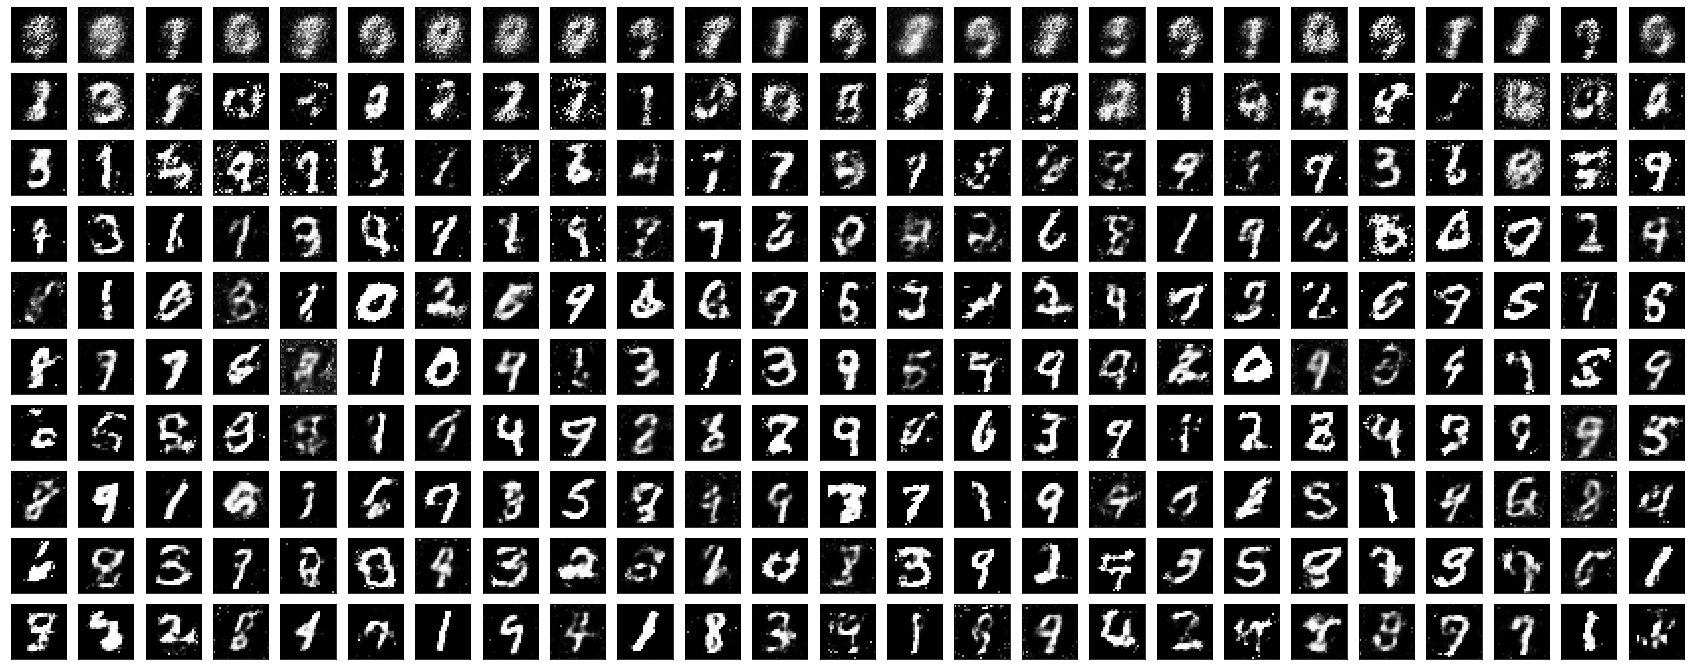

In [34]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs,int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28, 28)),cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)